## Random Forests model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split

def income_model_data_prep(data):
    data = pd.get_dummies(
        income.assign(
                target = np.where(data["SalStat"]==" less than or equal to 50,000", 0,1),
                nativecountry = data["nativecountry"].str.replace(" Holand-Netherlands",
                                                         " Germany"),
                JobType = data["JobType"].replace({" Never-worked":" Without-pay"}),
                occupation = data["occupation"].str.replace(" Armed-Forces"," ?")
                ).drop("SalStat",axis=1),
        drop_first=True
    )
    X = data.drop(columns=["target"],axis=1)
    y = data["target"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

    return X_train, X_test, y_train, y_test

In [3]:
## Split train and test datasets

income = pd.read_csv("../Data/income.csv")

X_train, X_test, y_train, y_test = income_model_data_prep(income)

In [5]:
## fit the dataset with a random forest model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1013)
rf.fit(X_train, y_train)

print(f'Train accuracy: {rf.score(X_train, y_train)}')
print(f'Test accuracy: {rf.score(X_test, y_test)}')

Train accuracy: 0.9793604878430147
Test accuracy: 0.8430268918073797


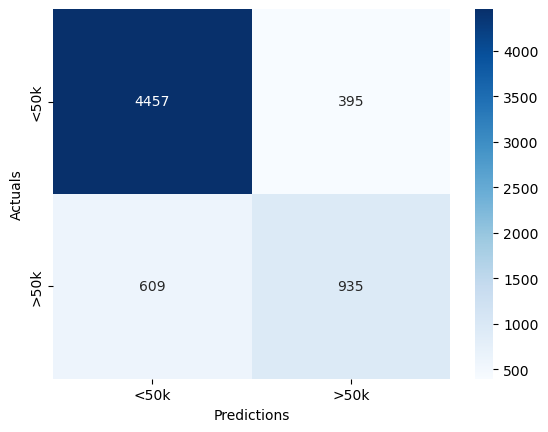

In [23]:
from sklearn.metrics import confusion_matrix
sns.heatmap(
    confusion_matrix(y_test, rf.predict(X_test)),
    annot=True,
    fmt='.0f',
    cmap='Blues',
    xticklabels=['<50k','>50k'],
    yticklabels=['<50k','>50k']
    # vmax = 1,
    # vmin = -1
)
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.show();

In [41]:
df = pd.DataFrame(
    {"feature":X_train.columns,
     "importance": rf.feature_importances_},
).sort_values('importance', ascending=False)

print(df)


                                      feature  importance
0                                         age    0.234612
3                                hoursperweek    0.116497
1                                 capitalgain    0.114251
27          maritalstatus_ Married-civ-spouse    0.080937
2                                 capitalloss    0.037732
..                                        ...         ...
89                    nativecountry_ Thailand    0.000084
10                       JobType_ Without-pay    0.000062
80  nativecountry_ Outlying-US(Guam-USVI-etc)    0.000055
86                    nativecountry_ Scotland    0.000048
68                    nativecountry_ Honduras    0.000004

[94 rows x 2 columns]


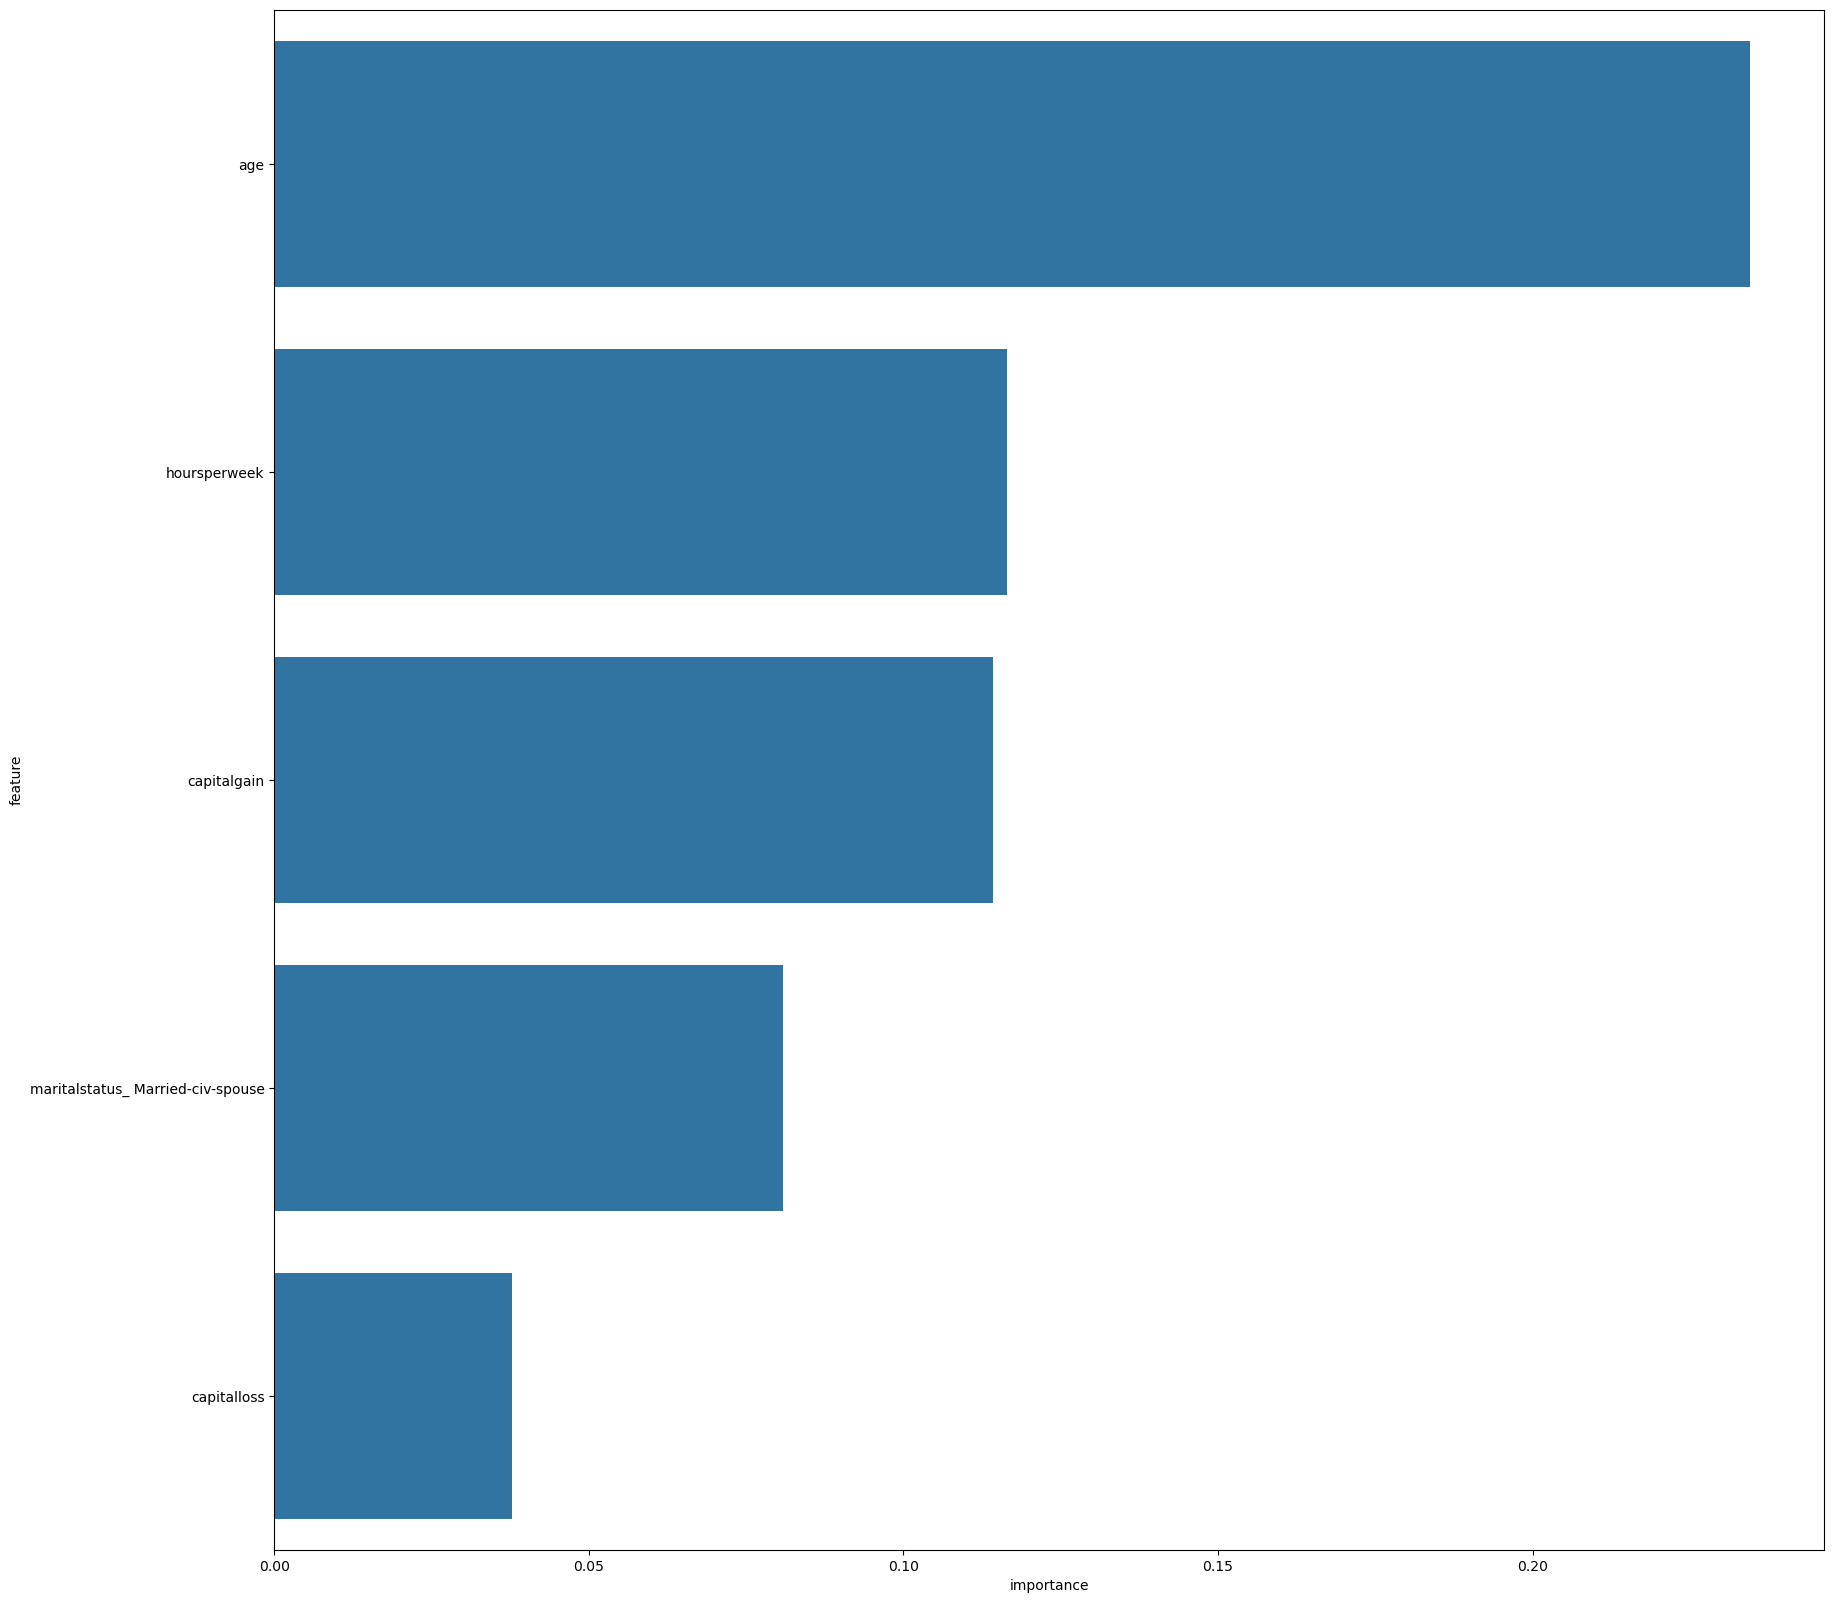

In [47]:
fig = plt.figure(figsize=(20,20))
sns.barplot(
    data=df[:5],
    x='importance',
    y='feature'
)
plt.show();

### Fine tune hyperparameters

In [51]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'n_estimators': np.arange(100,1100,100),
    'max_features': [None, 'sqrt'],
    'bootstrap': [True],
    'max_samples': [None, 0.3, 0.5, 0.9],
    'max_depth': np.arange(1, 11, 1),
    'min_samples_leaf': [2, 5, 10, 20, 100]
}

grid = RandomizedSearchCV(
    rf,
    param_distributions=params,
    n_iter=100,
    n_jobs=-1,
    scoring='accuracy'
)

grid.fit(X_train, y_train)
grid.best_params_

{'n_estimators': np.int64(100),
 'min_samples_leaf': 5,
 'max_samples': None,
 'max_features': None,
 'max_depth': np.int64(10),
 'bootstrap': True}

In [54]:
rf_tuned = RandomForestClassifier(**grid.best_params_)
rf_tuned.fit(X_train, y_train)

print(f'Tuned Accuracy: {rf_tuned.score(X_test, y_test)}')

Tuned Accuracy: 0.8642901813633521


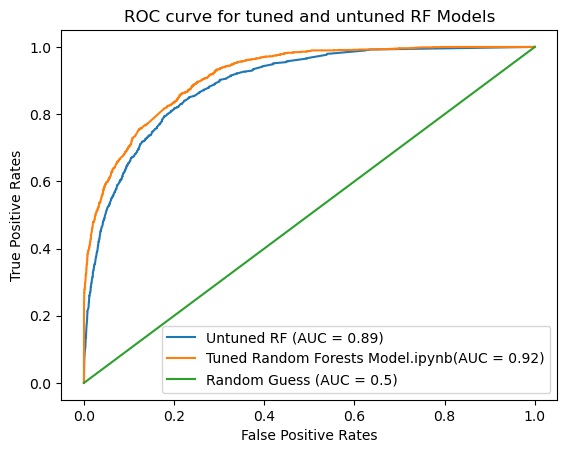

In [56]:
## Generate ROC-AUC metrics
from sklearn.metrics import roc_curve, auc

#Generate ROC AUC for untuned model
y_probs_untuned = rf.predict_proba(X_test)[:,1]
fpr_untuned, tpr_untuned, thresholds_untuned = roc_curve(y_test, y_probs_untuned)
auc_score_untuned = auc(fpr_untuned, tpr_untuned)

#Generate ROC AUC for tuned model
y_probs_tuned = rf_tuned.predict_proba(X_test)[:,1]
fpr_tuned, tpr_tuned, thresholds_tuned = roc_curve(y_test, y_probs_tuned)
auc_score_tuned = auc(fpr_tuned, tpr_tuned)

#Plot ROC curve
plt.plot(fpr_untuned, tpr_untuned, label=f'Untuned RF (AUC = {auc_score_untuned:0.2f})')
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned Random Forests Model.ipynb(AUC = {auc_score_tuned:0.2f})')

#Draw Random Guess
plt.plot([0,1],[0,1], label='Random Guess (AUC = 0.5)')

#Format the axes
plt.xlabel('False Positive Rates')
plt.ylabel('True Positive Rates')
plt.title('ROC curve for tuned and untuned RF Models')
plt.legend()
plt.show();
